# <h1><center>TP1 - Visión por computadora - CEIA</center></h1>

In [ ]:
%matplotlib inline
# Importaciones

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from typing import Callable
from matplotlib import colors

<center>

<img src="./resources/portada.jpeg" width="600" alt="Figura 1: A computer vision related image, with the text white patch and chromatic cooridantes on it - Generada con Microsoft Image Creator">

<small><em>Figura 1: A computer vision related image, with the text "white patch" and "chromatic cooridantes" on it - Generada con Microsoft Image Creator</em></small>

</center>

<center>
<em>Datos del proyecto:</em>

| Subtitulo       | TP1 - Visión por computadora - FIUBA                                                                                                   |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Aplicación de algoritmos white patch y coordenadas cromáticas, así como segmentación de imágenes                                       |
| **Integrantes** | • Bruno Masoller (brunomaso1@gmail.com)                                                                                                |

</center>

## Consinga

![Consinga](.\resources\Consigna.PNG)

## Parte 1

### 1. Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de contraste.

*Algoritmo:*

In [9]:
def coordenadas_cromaticas(img: np.ndarray) -> np.ndarray:
    """
    Calcula las coordenadas cromáticas de una imagen dada.

    La función transforma la imagen de entrada, calculando las coordenadas cromáticas para cada píxel,
    realizando la operación pixel a pixel.
    Las coordenadas cromáticas son obtenidas dividiendo los valores de cada canal de color (R, G, B) 
    por la suma de los valores de todos los canales para ese píxel.

    Args:
        img (np.array): Imagen de entrada en formato de matriz numpy con forma (x, y, z), 
                        donde x e y son las dimensiones de la imagen y z es el número de canales de color (generalmente 3 para RGB).

    Returns:
        np.array: Imagen de salida con las coordenadas cromáticas, con la misma forma que la imagen de entrada.
    """
    def aplicar_formula(pixel: np.ndarray) -> np.array:
        pixel_out = pixel.copy().astype(dtype='float')
        _sum = pixel_out[0] + pixel_out[1] + pixel_out[2]        
        pixel_out[0] = pixel_out[0] / _sum if _sum != 0 else 0
        pixel_out[1] = pixel_out[1] / _sum if _sum != 0 else 0
        pixel_out[2] = pixel_out[2] / _sum if _sum != 0 else 0
        return pixel_out

    img_out = np.copy(img)

    # Obtenemos las dimensiones de la imagen de entrada, para realizarle reshape.
    x, y, z = img_out.shape
    
    # Hacemos un reshape para obtener una matriz de m * n.
    img_out = img_out.reshape(x * y, z)
    
    # Aplicamos la transformación
    img_out = np.apply_along_axis(aplicar_formula, 1, img_out)
    
    img_out = img_out.reshape(x, y, z)

    return img_out

In [10]:
def coordenadas_cromaticas_optimizado(img: np.ndarray) -> np.ndarray:
    """
    Calcula las coordenadas cromáticas de una imagen dada (optimizado)

    La función transforma la imagen de entrada, calculando las coordenadas cromáticas para cada píxel,
    realizando las operaciones de forma matricial.
    Las coordenadas cromáticas son obtenidas dividiendo los valores de cada canal de color (R, G, B) 
    por la suma de los valores de todos los canales para ese píxel.

    Args:
        img (np.array): Imagen de entrada en formato de matriz numpy con forma (x, y, z), 
                        donde x e y son las dimensiones de la imagen y z es el número de canales de color (generalmente 3 para RGB).

    Returns:
        np.array: Imagen de salida con las coordenadas cromáticas, con la misma forma que la imagen de entrada.
    """
    img_out = np.copy(img)

    # Obtenemos las dimensiones de la imagen de entrada, para realizarle reshape.
    x, y, z = img_out.shape

    # Hacemos un reshape para obtener una matriz de m * n.
    img_out = img_out.reshape(x * y, z)

    # Obtenemos la suma sobre las filas.
    sum_row = np.sum(img_out, axis=1)

    # Aplicamos la transformación en forma matricial.
    # Utilizamos divide para manejar la división entre 0 más fácil, a diferencia de la división directa (/)
    # Al inicializar la imagen de salida con np.zeros_like(img_out, dtype=float), se maneja el condicional de asignar 0 cuando se divide entre 0.
    # Aplicamos la suma solamente si el divisor no es 0.
    # La sentencia sum_row[:, np.newaxis] permite cambiar la forma de sum_row de (n*m,) a (n*m,1), es lo mismo que hacer reshape(n*m,1). Esto permite la división elemento a elemento con img_out.
    # Finalmente, hacemos un reshape a la forma original (3d) y la devolvemos.
    return np.divide(img_out, sum_row[:, np.newaxis], out=np.zeros_like(img_out, dtype=float), where=sum_row[:, np.newaxis] != 0).reshape(x, y, z)

*Procesamiento de las imágenes:*

In [11]:
# Mostramos las imágenes
def mostrar_imagenes_transf(img_list: list, transformacion: Callable[[np.ndarray], np.ndarray], figsize: tuple = (5,8)):
    fig, axs = plt.subplots(len(img_list), 2, figsize=figsize)
    fig.tight_layout()
    for i, img in enumerate(img_list):
        row_axis = axs[i]
        
        row_axis[0].imshow(img[:, :, ::-1])
        row_axis[0].set_title('Original')
        
        row_axis[1].imshow(transformacion(img)[:, :, ::-1])
        row_axis[1].set_title('Transformada')
        
    plt.show()

In [12]:
# Cargamos las imagenes
img_list = [cv.imread(
    f'./resources/coord_cromaticas/CoordCrom_{i}.png') for i in range(1, 4)]

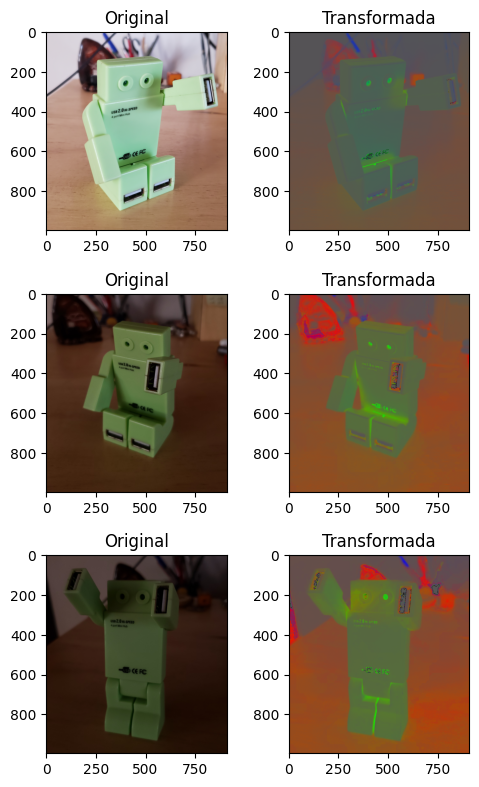

In [13]:
# Mostramos la transformación aplicada
mostrar_imagenes_transf(img_list, coordenadas_cromaticas_optimizado)

### 2. Impelementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.

*Algoritmo:*

In [14]:
def balance_blancos(img: np.ndarray) -> np.ndarray:
    def aplicar_formula(pixel_bgr: np.ndarray) -> np.ndarray:
        pixel_bgr_out = pixel_bgr.copy()
        pixel_bgr_out[0] = factor_b * pixel_bgr_out[0] if factor_b * pixel_bgr_out[0] <= 255 else 255
        pixel_bgr_out[1] = factor_g * pixel_bgr_out[1] if factor_g * pixel_bgr_out[1] <= 255 else 255
        pixel_bgr_out[2] = factor_r * pixel_bgr_out[2] if factor_r * pixel_bgr_out[2] <= 255 else 255
        return pixel_bgr_out

    img_out = np.copy(img)

    # Obtengo cada canal
    ch_b, ch_g, ch_r = cv.split(img_out)

    # Obtengo el máximo de cada canal.
    r_max, g_max, b_max = ch_r.max(), ch_g.max(), ch_b.max()

    if r_max == 0 or g_max == 0 or b_max == 0:
        raise ValueError(
            f'El máximo de algún canal es 0: (R,G,B)->({r_max},{g_max},{b_max})')
        
    factor_r, factor_g, factor_b = 255/r_max, 255/g_max, 255/b_max

    # Obtenemos las dimensiones de la imagen de entrada, para realizarle reshape.
    x, y, z = img_out.shape
    
    # Hacemos un reshape para obtener una matriz de m * n.
    img_out = img_out.reshape(x * y, z)
    
    # Aplicamos la transformacion
    img_out = np.apply_along_axis(aplicar_formula, 1, img_out)
    
    # La volvemos de punto flotante a entero (entre 0 y 255)
    img_out = img_out.astype('uint8')
    
    # Volemos de vuelta la forma original (3d)
    img_out = img_out.reshape(x, y, z)

    return img_out

In [15]:
def balance_blancos_optimizado(img: np.ndarray) -> np.ndarray:
    img_out = np.copy(img)

    # Obtenemos las dimensiones de la imagen de entrada, para realizarle reshape.
    x, y, z = img_out.shape

    # Hacemos un reshape para obtener una matriz de m * n.
    img_out = img_out.reshape(x * y, z)

    # Dividimos 255 por el máximo de cada columna
    factor_rgb = 255/np.max(img_out, axis=0)

    return np.multiply(img_out, factor_rgb, out=np.zeros_like(img_out, dtype=float)).clip(max=255).astype('uint8').reshape(x, y, z)

*Procesamiento:*

In [16]:
# Obtener todos los archivos en el directorio
def obtener_img_directorio(directory: str) -> list:
    # Obtener todos los archivos en el directorio
    archivos = os.listdir(directory)

    extensiones_validas = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    archivos_imagenes = [archivo for archivo in archivos if os.path.splitext(
        archivo)[1].lower() in extensiones_validas]

    imagenes = []
    for archivo in archivos_imagenes:
        path_completo = os.path.join(directory, archivo)
        imagen = cv.imread(path_completo)
        if imagen is not None:
            imagenes.append(imagen)
        else:
            raise RuntimeError('No se pudo cargar la imagen')
        
    return imagenes

In [17]:
# Cargamos las imagenes.
img_list = obtener_img_directorio('./resources/white_patch/')

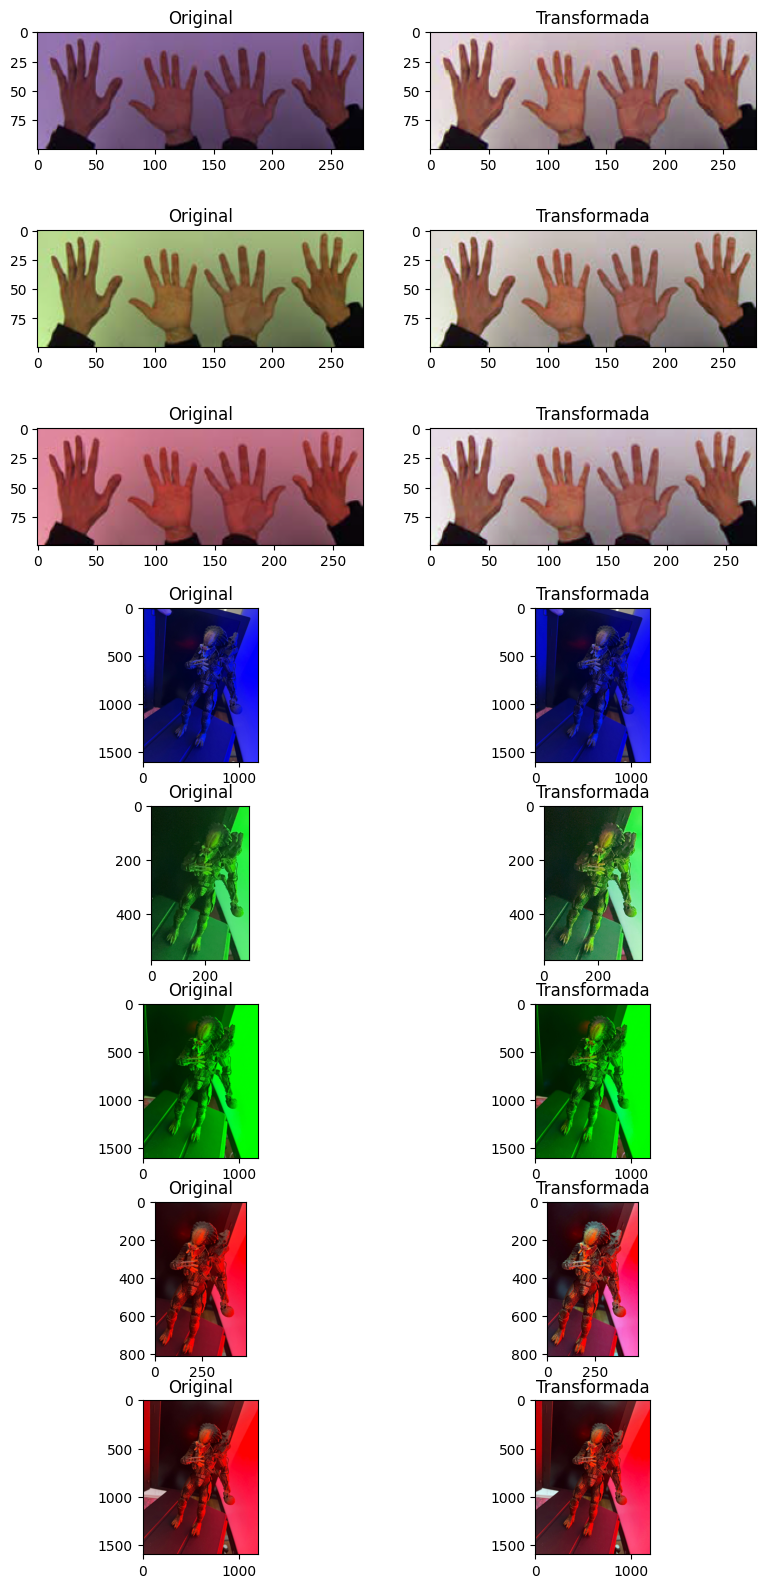

In [18]:
# Mostramos la transformación aplicada
mostrar_imagenes_transf(img_list, balance_blancos_optimizado, figsize=(8,16))

### 3. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White Patch

*El problema que puede estar pasando, es que las imágenes del alien pueden estar saturando los canales respectivamente. O sea, cuando se busca el máximo de cada canal, éste es 255, por lo que cuando se hace la división se mantiene el mismo valor.*

In [19]:
img = cv.imread('./resources/white_patch/wp_red2.jpg')
ch_b, ch_g, ch_r = cv.split(img)
ch_r.max()


255

*Una posible solución, podría ser utilizar un percentil como parámetro, hacer un clip por dicho percentil:*

In [20]:
def balance_blancos_optimizado(img: np.ndarray, porc_percentil: int = 100) -> np.ndarray:
    img_out = np.copy(img)

    # Obtenemos las dimensiones de la imagen de entrada, para realizarle reshape.
    x, y, z = img_out.shape

    # Hacemos un reshape para obtener una lista de m * n.
    img_out = img_out.reshape(x * y, z)

    # Dividimos 255 por el máximo de cada columna
    factor_rgb = 255/np.max(img_out, axis=0)

    return np.multiply(img_out, factor_rgb, out=np.zeros_like(img_out, dtype=float)).clip(max=255*porc_percentil/100).astype('uint8').reshape(x, y, z)

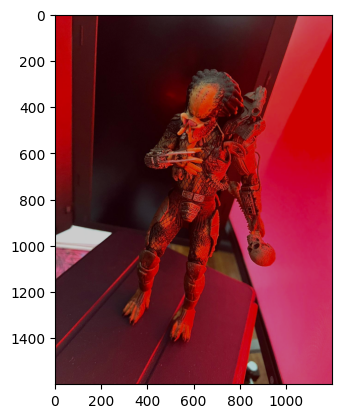

In [21]:
img = cv.imread('./resources/white_patch/wp_red2.jpg')
img = balance_blancos_optimizado(img, 80)

plt.figure()
plt.imshow(img[:, :, ::-1])
plt.show()

## Parte 2

### 1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grises y visualizarlas.

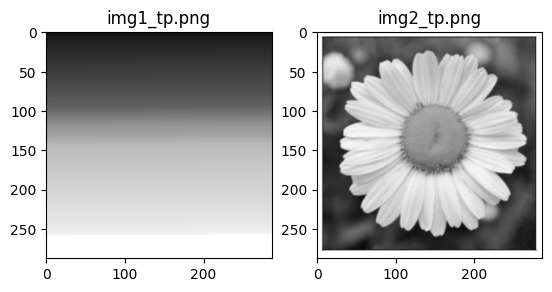

In [22]:
img_list = [cv.imread(
    f'./resources/img{i}_tp.png', cv.IMREAD_GRAYSCALE) for i in range(1, 3)]

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img_list[0], cmap='gray')
axes[0].set_title('img1_tp.png')

axes[1].imshow(img_list[1], cmap='gray')
axes[1].set_title('img2_tp.png')
plt.show()

### 2. Elija el número de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuvera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como 'features' a los histogramas?

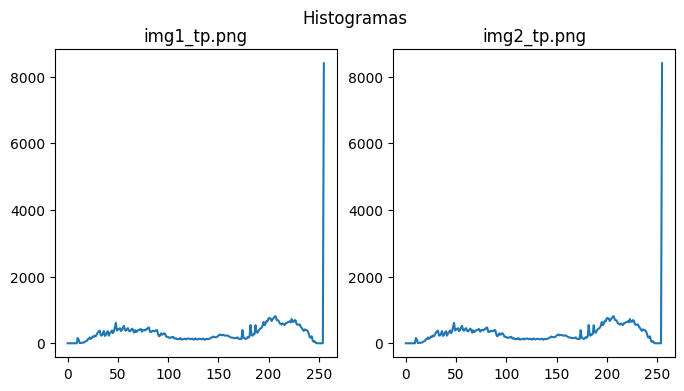

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Histogramas')
img1_hist, _ = np.histogram(img_list[0].flatten(), 256, [0, 256])
axes[0].plot(img1_hist)
axes[0].set_title('img1_tp.png')

img2_hist, _ = np.histogram(img_list[1].flatten(), 256, [0, 256])
axes[1].plot(img2_hist)
axes[1].set_title('img2_tp.png')

plt.show()

*En este caso, no nos serviría utilizar un histograma como "feature". Esto es porque no hay forma de diferenciar una imagen de la otra mediante el histograma, es decir, ambas imágenes tienen la misma cantidad de intensidad de píxeles (blanco y negro), solamente que en un orden distinto.*

### 3. Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente alguno de los elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando máscaras, las regiones en imágenes separadas. 

In [24]:
img = cv.imread('./resources/segmentacion.png')

# Convertimos la imagen a RGB y HSV respectivamente para su estudio
imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
imgHSV = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# Separamos los canales para el procesamiento
ch_r, ch_g, ch_b = cv.split(imgRGB)
ch_h, ch_s, ch_v = cv.split(imgHSV)

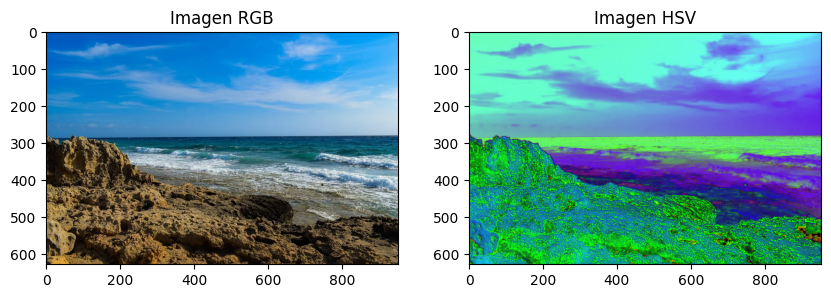

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(imgRGB)
axes[0].set_title('Imagen RGB')

axes[1].imshow(imgHSV)
axes[1].set_title('Imagen HSV')
plt.show()

*Primeramente, graficamos la distribución de los colores para ver si hay una clara separación en RGB:*

In [26]:
def scatter_3d_ax(img: np.ndarray, ax: plt.Axes) -> plt.Axes:
    c1, c2, c3 = cv.split(img)

    # Pasamos a una dimensión, o sea, una lista con elementos que son listas con 3 elementos.
    pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1], 3))
    norm = colors.Normalize(vmin=-1., vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    ax.scatter(c1.flatten(), c2.flatten(), c3.flatten(),
                 facecolors=pixel_colors, marker=".")
    ax.set_xlabel("Canal 1")
    ax.set_ylabel("Canal 2")
    ax.set_zlabel("Canal 3")
    return ax

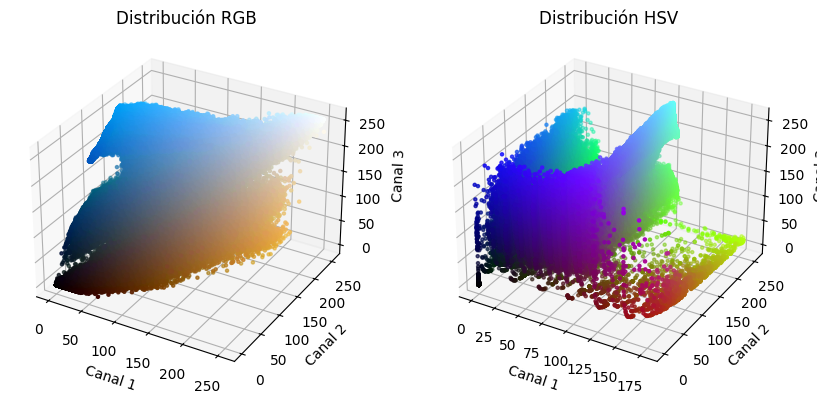

In [27]:
# Para rotación:
# %matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(121, projection='3d')
ax = scatter_3d_ax(imgRGB, ax)
ax.set_title('Distribución RGB')

ax = fig.add_subplot(122, projection='3d')
ax = scatter_3d_ax(imgHSV, ax)
ax.set_title('Distribución HSV')
plt.show()

*Podemos ver que en RGB no hay una separación clara para la segmentación. Sin embargo, en HSV parecería ser mejor la separación.*

*Trazamos un perfil para cada imagen sobre la columna 500 para verificar esto:*

In [28]:
def graficar_perfil_ax(img: np.ndarray, idx_col: int, ax: plt.Axes) -> plt.Axes:
    c1, c2, c3 = cv.split(img)

    ax.plot(c1[:, idx_col], color='r', label='canal c1')
    ax.plot(c2[:, idx_col], color='g', label='canal c2')
    ax.plot(c3[:, idx_col], color='b', label='canal c3')
    ax.set_xlabel('Fila')
    ax.set_ylabel('Intensidad')
    ax.grid()
    ax.legend()

    return ax

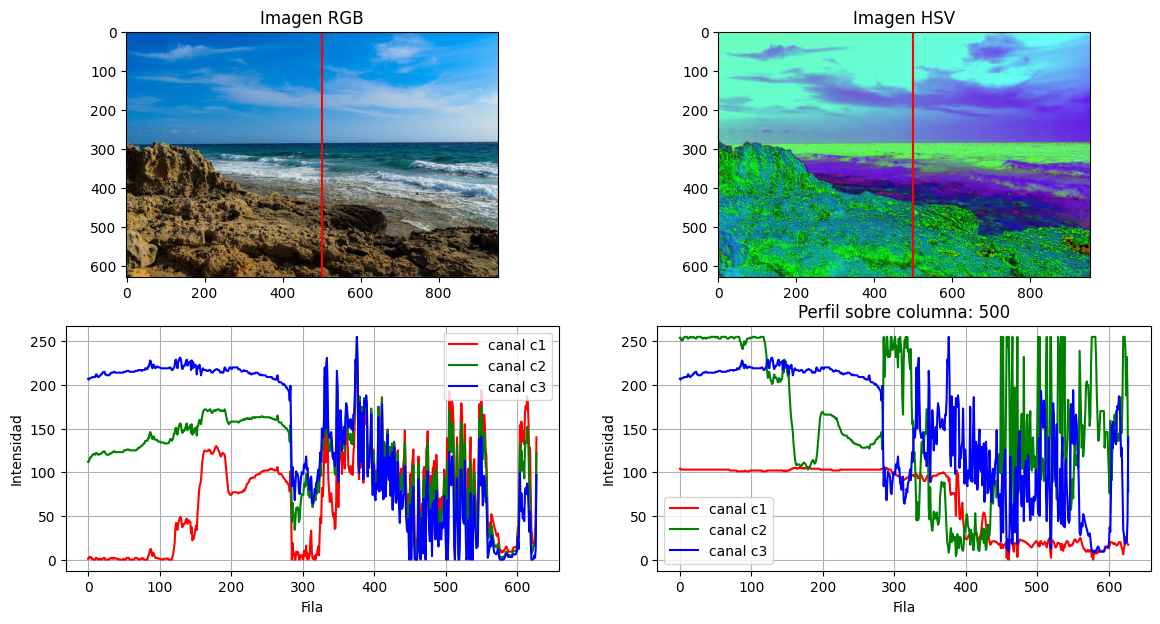

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
idx_col = 500
plt.title(f'Perfil sobre columna: {idx_col}')

axes_row = axes[0]
# Columna 1
axes_row[0].imshow(imgRGB)
axes_row[0].axvline(x=idx_col, color='r', label='axvline - full height')
axes_row[0].set_title('Imagen RGB')

# Columna 2
axes_row[1].imshow(imgHSV)
axes_row[1].axvline(x=idx_col, color='r', label='axvline - full height')
axes_row[1].set_title('Imagen HSV')

axes_row = axes[1]
# Columna 1
axes_row[0] = graficar_perfil_ax(imgRGB, idx_col, axes_row[0])

# Columna 2
axes_row[1] = graficar_perfil_ax(imgHSV, idx_col, axes_row[1])

plt.show()

*Podemos observar que la dimensión que se mantiene "más" constante en el espacio HSV, es el "Hue", sin embargo, también tiene pequenas variaciones que dificultan la segmentación.*

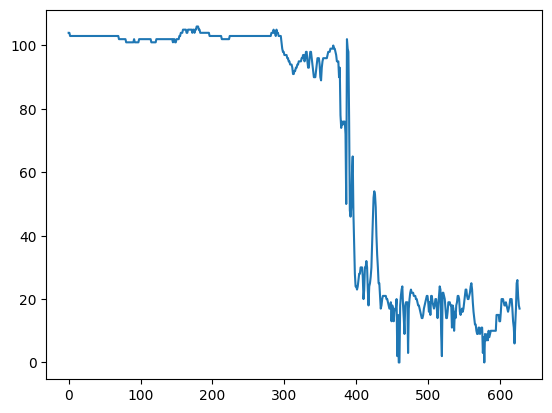

In [30]:
plt.figure()
plt.plot(ch_h[:,idx_col])
plt.show()

*Segmentación:*

*Primeramente tomamos las muestras para realizar la segmentcación en el espacio HSV sobre la dimensión H.*

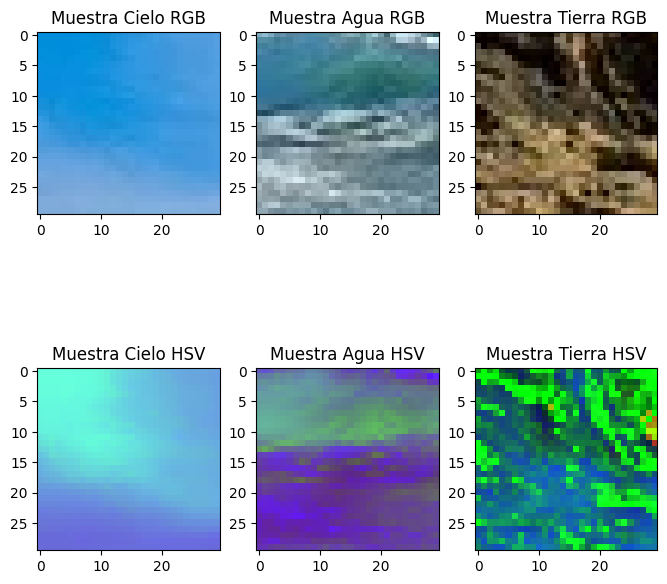

In [31]:
idx_cielo_row = 150
idx_agua_row = 350
idx_tierra_row = 500
desviacion = 15

muestras_rgb = [imgRGB[idx_cielo_row - desviacion: idx_cielo_row + desviacion, idx_col - desviacion: idx_col + desviacion, :],
                imgRGB[idx_agua_row - desviacion: idx_agua_row + desviacion,
                       idx_col - desviacion: idx_col + desviacion, :],
                imgRGB[idx_tierra_row - desviacion: idx_tierra_row + desviacion, idx_col - desviacion: idx_col + desviacion, :]]
muestras_hsv = [imgHSV[idx_cielo_row-desviacion:idx_cielo_row+desviacion, idx_col-desviacion:idx_col + desviacion, :],
                imgHSV[idx_agua_row-desviacion:idx_agua_row + desviacion,
                       idx_col-desviacion:idx_col + desviacion, :],
                imgHSV[idx_tierra_row-desviacion:idx_tierra_row+desviacion, idx_col-desviacion:idx_col + desviacion, :]]

fig, axes = plt.subplots(2, 3, figsize=(8, 8))
# Columna 1
axes_row = axes[0]
for i, muestra_titulo in enumerate(zip(muestras_rgb, ["Muestra Cielo RGB", "Muestra Agua RGB", "Muestra Tierra RGB"])):
    axes_row[i].imshow(muestra_titulo[0])
    axes_row[i].set_title(muestra_titulo[1])

# Columna 2
axes_row = axes[1]
for i, muestra_titulo in enumerate(zip(muestras_hsv, ["Muestra Cielo HSV", "Muestra Agua HSV", "Muestra Tierra HSV"])):
    axes_row[i].imshow(muestra_titulo[0])
    axes_row[i].set_title(muestra_titulo[1])

plt.show()

*Creamos las máscaras y las aplicamos a la imagen:*

Media muestra cielo: 102.95111111111112
Media muestra agua: 97.2688888888889
Media muestra tierra: 18.913333333333334


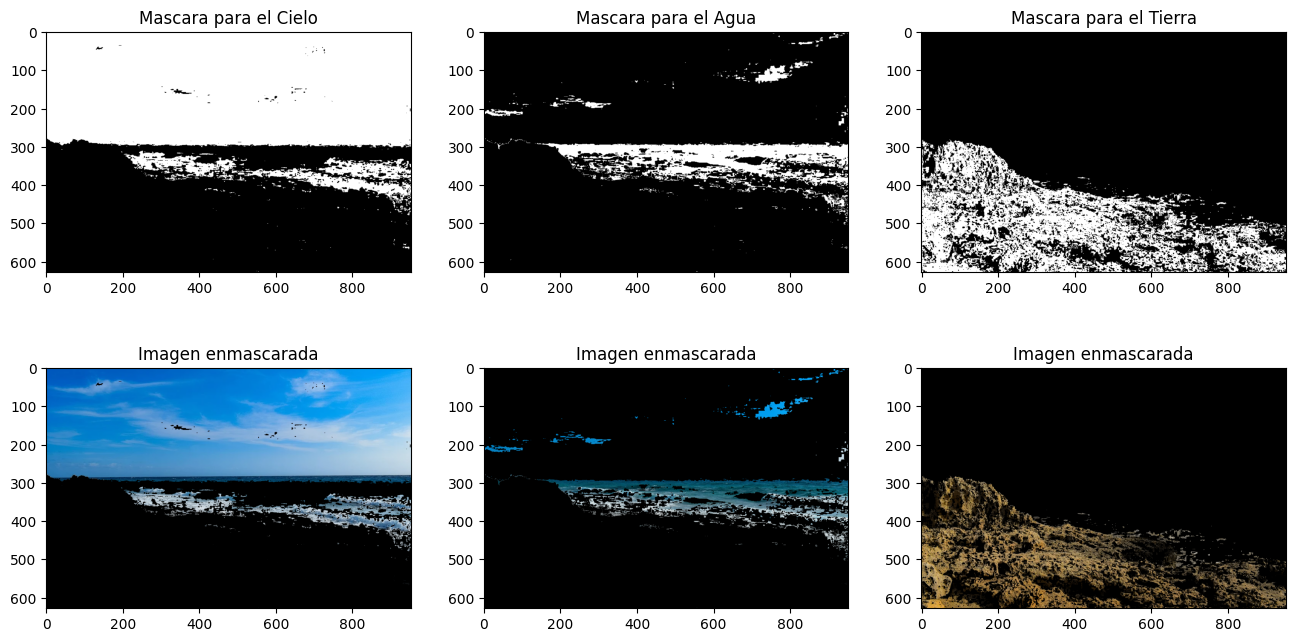

In [55]:
# Creamos una lista con la media de cada muestra
muestras_h = list(
    map(lambda muestra: muestra[:, :, 0].flatten().mean(), muestras_hsv))

print(f'Media muestra cielo: {muestras_h[0]}')
print(f'Media muestra agua: {muestras_h[1]}')
print(f'Media muestra tierra: {muestras_h[2]}')

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for i, muestra_titulo in enumerate(zip(muestras_h, ["Cielo", "Agua", "Tierra"])):
    color_h_medio = muestra_titulo[0]
    titulo = muestra_titulo[1]

    # Mascara
    color_l = (color_h_medio-3, 0, 0)
    color_u = (color_h_medio+3, 255, 255)
    mask = cv.inRange(imgHSV, color_l, color_u)
    axes[0][i].imshow(mask, cmap='gray')
    axes[0][i].set_title(f'Mascara para el {titulo}')
    
    # Aplicacion de la máscara
    img_segmentada = cv.bitwise_and(imgRGB, imgRGB, mask=mask)
    axes[1][i].imshow(img_segmentada)
    axes[1][i].set_title(f'Imagen enmascarada')

*Para una mejor segmentación, se podría utilizar la información de "donde" hasta "donde" tomar la media también en la dimensión del "Hue", ya que se puede ver en el gráfico que se divide en tres partes prácticamente.*